# Example 3: stiff linear polyimides with multiple bond cycles
This demo is shows how polymerist's fragmenation algorthims can handle polymerization routes with more complicated   
bond rearrangements than simple addition and condensation polymerizations, like that featured in the [basics demo](0-nylon-basics.ipynb)

## Output config

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, disable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

disable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Define chemically-complete monomer "feedstocks"
Here we consider DuPont's Kapton, a common film polyimide with favorable thermal and electrical properties

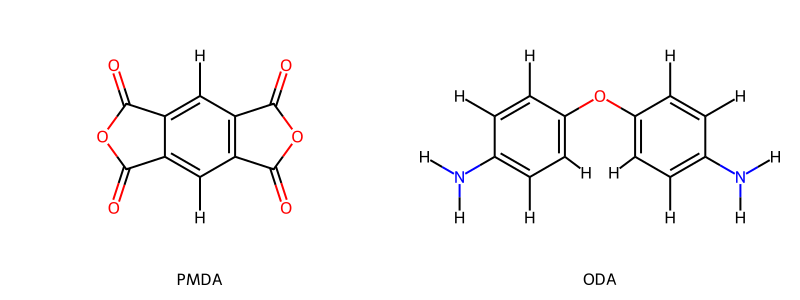

In [2]:
from rdkit.Chem.rdchem import Mol
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles


monomer_smiles : dict[str, Smiles] = {
    'PMDA' :  'c1c2C(=O)OC(=O)c2cc3C(=O)OC(=O)c31', # pyromellitic-dianhydride
    'ODA' : 'O(c1ccc(N)cc1)c2ccc(cc2)N', # 4,4′-oxydianiline
}
monomers : dict[str, Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=monomers.keys())

### The importance of aromaticity model

Worth highlighting here are the implicit molecular sanitation and aromaticity settings being passed when loading a molecule  

The [default aromaticity model in RDKit](https://www.rdkit.org/docs/RDKit_Book.html#the-rdkit-aromaticity-model) actually incorrectly aromatizes PMDA, inserting nonsensical pentavalent carbons into its carbonyls; the choice of  
an ["OpenEye-like aromaticity model"](https://docs.eyesopen.com/toolkits/cpp/oechemtk/aromaticity.html#aromaticity-models-in-oechem-tk) ("AROMATICITY_MDL") assigns the   correct valences and ensures the polyimide reactions downstream proceed as expected  

`polymerist` by default elects AROMATICITY_MDL, and ensures this choice is respected even when using "SANITIZE_ALL" for chemical sanitization;  
In short, all demos presented will behave as intended without these settings explicitly passed  

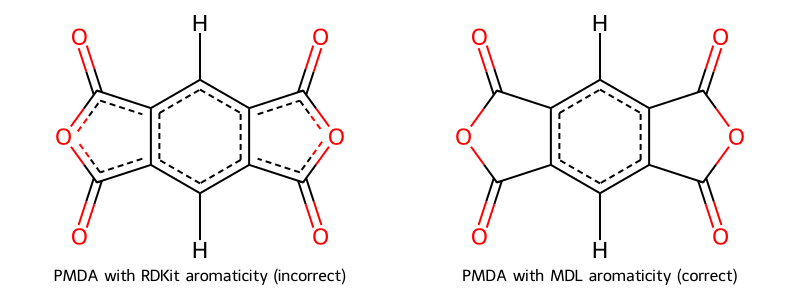

In [3]:
from rdkit.Chem.rdmolops import SANITIZE_ALL, AROMATICITY_MDL, AROMATICITY_RDKIT

from rdkit.Chem.Draw import MolDrawOptions
draw_opts = MolDrawOptions()
draw_opts.prepareMolsBeforeDrawing = False # prevent grid image from displaying aromatic molecules as kekulized


pmda_aromaticity_example : dict[str, Mol] = {
    'PMDA with RDKit aromaticity (incorrect)' : explicit_mol_from_SMILES(
        monomer_smiles['PMDA'],
        sanitize_ops=SANITIZE_ALL,
        aromaticity_model=AROMATICITY_RDKIT,
    ),
    'PMDA with MDL aromaticity (correct)' : explicit_mol_from_SMILES(
        monomer_smiles['PMDA'],
        sanitize_ops=SANITIZE_ALL,
        aromaticity_model=AROMATICITY_MDL,
    ),
}

MolsToGridImage(
    pmda_aromaticity_example.values(), 
    molsPerRow=len(pmda_aromaticity_example), 
    subImgSize=MOL_IMG_SIZE, 
    legends=pmda_aromaticity_example.keys(), 
    drawOptions=draw_opts
)

## Define reaction template for polymerization reaction
For simplicity, we disregard initiation and consider one of the end groups of the polymer to be an unreacted vinyl

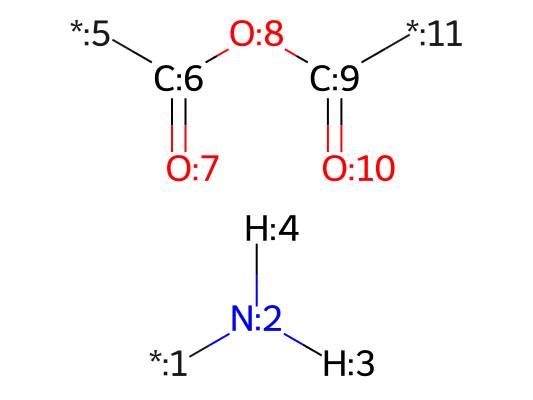

In [4]:
from rdkit.Chem.rdmolfiles import MolFromSmarts, MolToSmiles
from polymerist.rdutils.reactions import ReactionAssembler


assem = ReactionAssembler(
    reactive_groups=[
        MolFromSmarts('*-N(-[H])(-[H])'),       # amine
        MolFromSmarts('*-C(=O)-O-C(=O)-*'), # anhydride, with 2 R-groups (which belong to the same ring in this example)
    ],
    byproducts=[MolFromSmarts('[H]-[O]-[H]')], # water gets kicked off in hydrolysis of intermediate
    rxn_name='polyimide condensation',
)
display(assem.reactants)

For this polyimide condensation, we combine the nucleophilic attack of the amine nitrogen and the hydrolysis of the intermediate into one step  
This amount to having TWO complete bond cycles involving to swap the oxygen and amine "crowns" of the monomers  

This ought to make clearer the bond-cycle notation for assembling reactions; it handles more complicated reactions such as this just as easily

INFO:polymerist.rdutils.bonding.permutation:3 --x-> 2


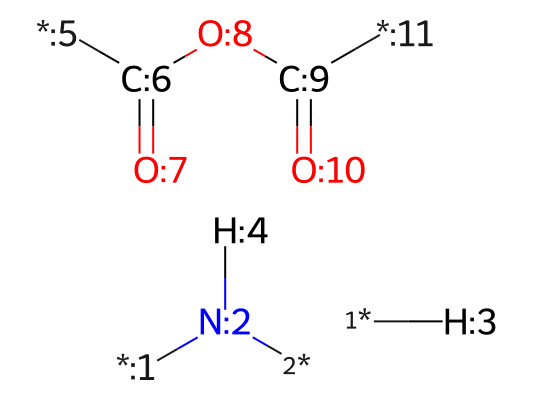

INFO:polymerist.rdutils.bonding.permutation:6 --x-> 8


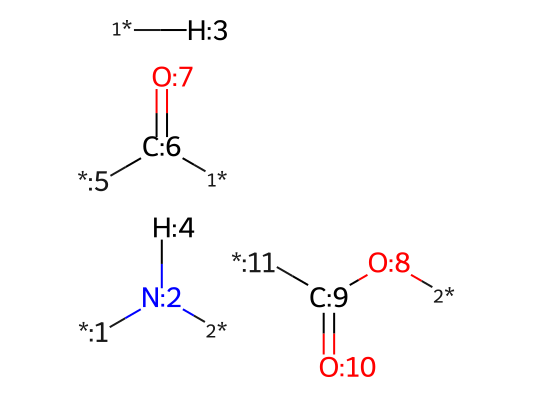

INFO:polymerist.rdutils.bonding.permutation:4 --x-> 2


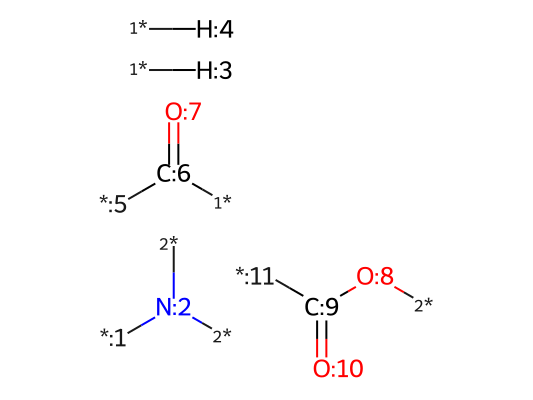

INFO:polymerist.rdutils.bonding.permutation:9 --x-> 8


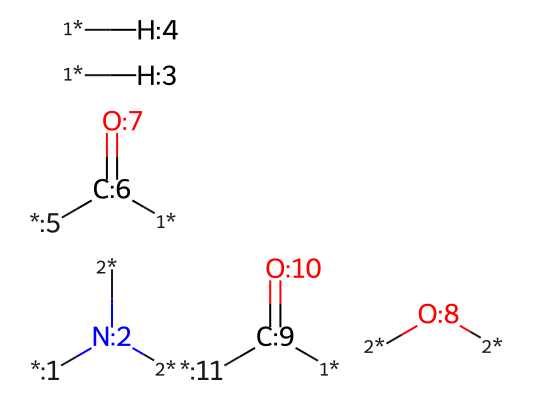

INFO:polymerist.rdutils.bonding.permutation:3 ----> 8


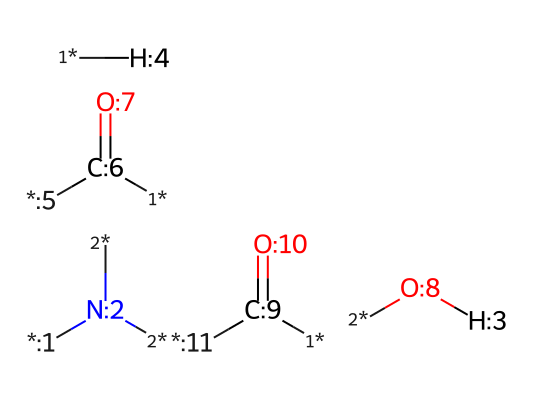

INFO:polymerist.rdutils.bonding.permutation:6 ----> 2


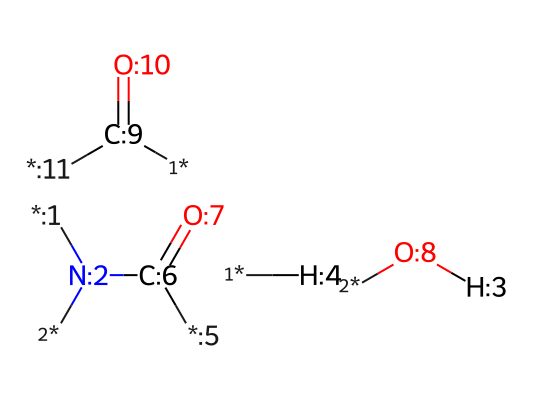

INFO:polymerist.rdutils.bonding.permutation:4 ----> 8


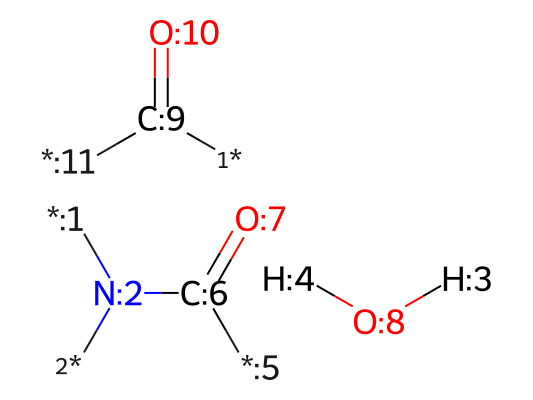

INFO:polymerist.rdutils.bonding.permutation:9 ----> 2


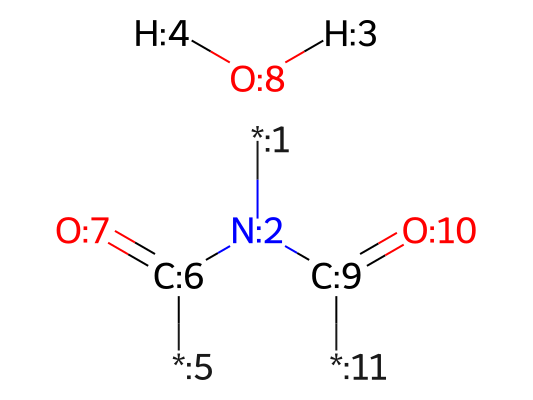

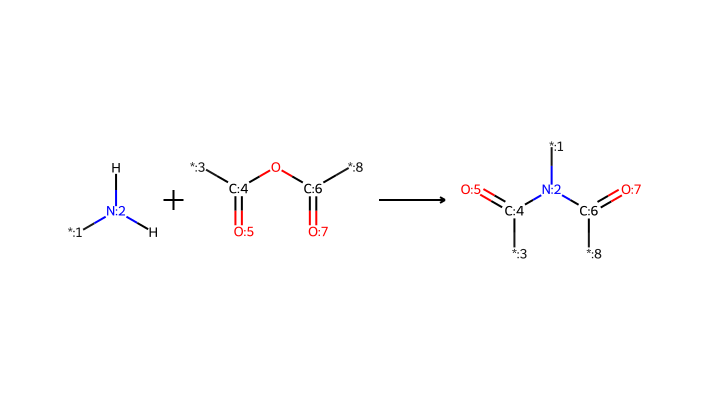

In [5]:
assem.bond_derangement = {
    # cycle for the "left" carbonyl (#6)...
    3 : (2, 8),
    6 : (8, 2),
    # ...and corresponding cycle for the "right" carbonyl (#9)
    4 : (2, 8),
    9 : (8, 2),
}

rxn = assem.assemble_rxn(show_steps=True)
rxn_smarts = rxn.to_smarts()
display(rxn)

### Export reaction for re-use

In [6]:
from polymerist.genutils.fileutils import assemble_path


rxn_smarts = rxn.to_smarts()
rxn_path = assemble_path('polymer_build_files/rxns', prefix=rxn.rxnname, extension='rxn')
rxn_path.parent.mkdir(exist_ok=True, parents=True)
rxn.to_rxnfile(rxn_path)

## Enumerate all possible repeat unit fragments from monomers and reaction template
Many users might look at the fragments enumerated below, see they look like reasonable linear repeat units, and move on with their day without a second thought  
However, the astute user will probably be wondering _how_ this fragmentation is done, especially given that a naive procedure **wouldn't work** for this polyimide example

In a nutshell, at each reaction propagation step a dimer is formed between two compatible fragments (as defined by the reaction template we generated above),  
which is then cut according to a series of heuristics to produce a new set of fragments. If these fragments have not been encoutered before, they are added to the pool.  

The heuristics `polymerist`'s fragment algorithm employs have been chosen to minimize the number of cuts made,  
and to target bonds loosely according to human chemical intuition. Namely, the choice of cut bonds is weighted by:
* Bonds newly-formed by the reaction, as these often cross the "[bracketed](https://www.pharmacy180.com/article/definitions-and-architectures-of-polymers-2760/)" repeat units in polymerized systems
* Bonds which are "[bridges](https://en.wikipedia.org/wiki/Bridge_(graph_theory))" (i.e. uctting them would increase the number of fragments in the molecular system)
* Bonds which are NOT next to R-groups (linkers), to avoid degenerate "neutronium" (*-*) fragments

The implementation of this and other fragmentation strategies can be found in the [polymerist.rdutils.reactions.fragment](https://github.com/timbernat/polymerist/blob/main/polymerist/rdutils/reactions/fragment.py), as imported below  
If you're unhappy with these rules or want to play with fragmentation criteria, you can implement your own fragment strategy by writing a class which inherits from   
[.fragment.IntermonomerBondIdentificationStrategy](https://github.com/timbernat/polymerist/blob/main/polymerist/rdutils/reactions/fragment.py#L18-L34) and implements the "_locate_intermonomer_bonds(self, product : Mol)" method, then that to the "fragment_strategy" argument of PolymerizationReactor

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


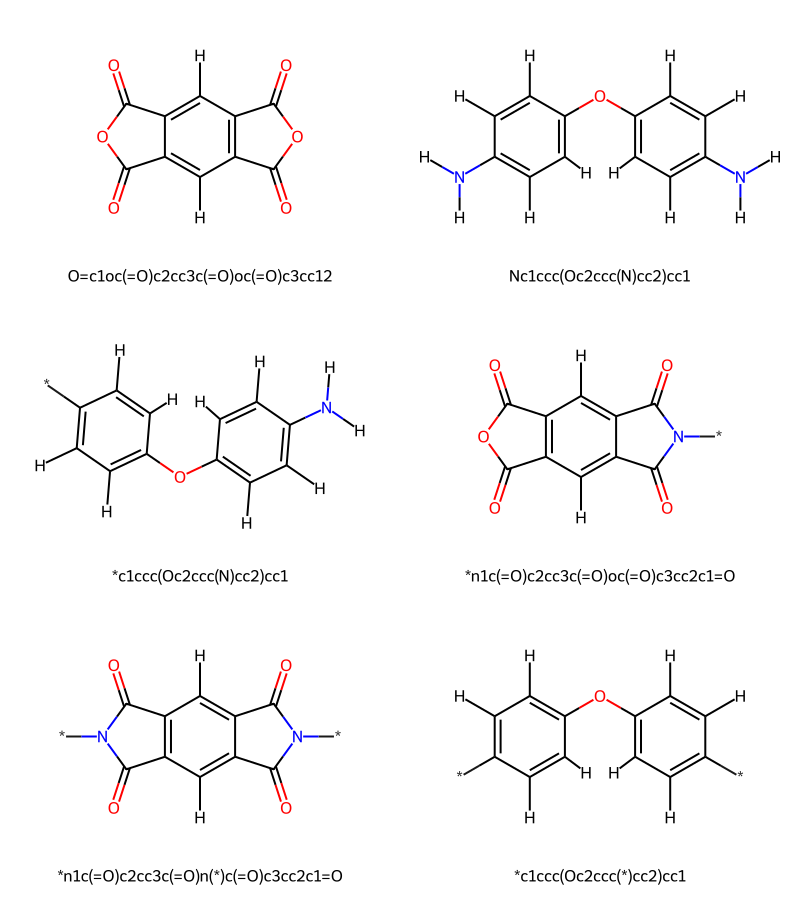

In [7]:
from polymerist.rdutils.reactions import AnnotatedReaction, PolymerizationReactor
from polymerist.rdutils.reactions.fragment import CutMinimumCostBondsStrategy


reactor = PolymerizationReactor(
    rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts),
    fragment_strategy=CutMinimumCostBondsStrategy()
)
fragments = reactor.propagate_pooled(
    monomers.values(),
    rxn_depth_max=3,
    # NOTE here that we explicitly pass in sanitization and aromaticity preferences, albeit the ones polymerist already uses by default
    sanitize_ops=SANITIZE_ALL,
    aromaticity_model=AROMATICITY_MDL,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=fragments.keys())

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment
Notice that the PMDA fragments generated for this polyimide mechanism are not substructures of their source monomers;  
this will in general be the case, and unfortunately means the substructure-based heuristic we used for procedural naming  
of fragments in other demos won't work here. There is no "one-size-fits-all" heuristic for choosing meaningful names for fragments procedurally  


Here we opt for the more generic approach of naming fragment by their functionality (number of linker sites) with distinguishing alphanumeric labels,      
which is well-suited for high-throughput workflows where one can't decide on chemistry-specific names on a case-by-case basis

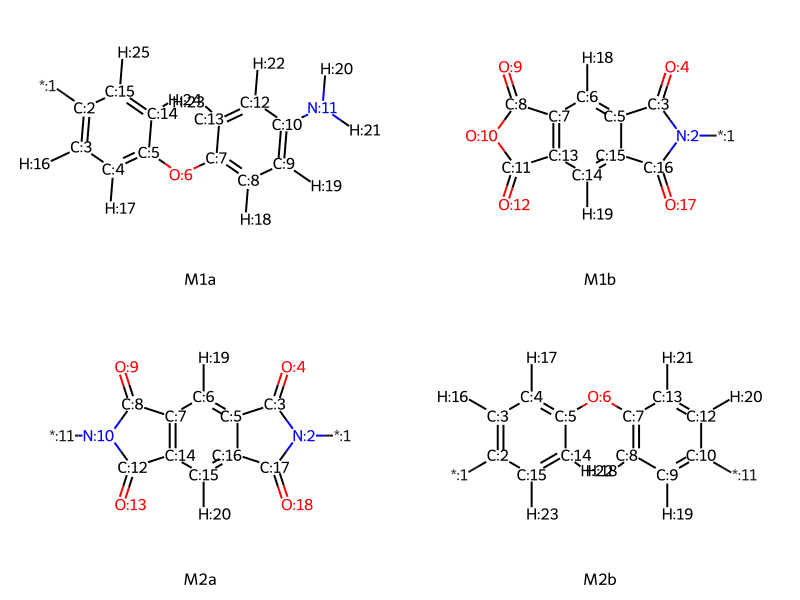

In [8]:
from string import ascii_lowercase
from collections import Counter

from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports


seen_functionalities : Counter[int] = Counter()

fragment_prefix : str = 'M'
named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    functionality_suffix = ascii_lowercase[seen_functionalities[functionality]]  # use a letter to distinguish fragments of the same functionality
    seen_functionalities[functionality] += 1

    named_fragments[f'{fragment_prefix}{functionality}{functionality_suffix}'] = canon_smiles

monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

## Use fragments to assemble a polymer

In [9]:
from polymerist.polymers.building import build_linear_polymer


# these are for you to configure
n_monomers : int = 80
do_energy_min : bool = False # if enable, will yield more physically-plausible structure, at the cost of slower structure output

monogrp.term_orient = {
    'head' : f'M1a',
    'tail' : f'M1b',
}
chain = build_linear_polymer(
    monomers=monogrp,
    sequence='AB', # will alternate M2a and M2b ("A" just denotes the first 2-site monomer among the MonomerGroup fragment, in-order)
    n_monomers=n_monomers,
    energy_minimize=do_energy_min, # disabling this will make PDB generation much faster but give less physical structures
)
chain.visualize()

[12:57:47] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'M1a', 'tail': 'M1b'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "AB" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 39 whole 2-sequence repeat(s), namely with the sequence [M1a] + 39*[AB] + [M1b]
INFO:polymerist.polymers.building.linear:Registering middle monomer M2a (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering middle monomer M2b (block identifier "B")
INFO:polymerist.polymers.building.linear:Registering terminal monomer M1a (orientation "head")
INFO:polymerist.polymers.building.linear:Registering terminal monomer M1b (orientation "tail")
INFO:polymerist.polymers.building.linear:Assembling linear 80-mer chain (estimated 1563 atoms)
INFO:polymerist.polymers.building.linear:Successfully assembled linear 

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Export polymer structure files

In [10]:
from pathlib import Path

polymer_name : str = 'Kapton'
structures_dir = Path('polymer_build_files/structures') / polymer_name
structures_dir.mkdir(exist_ok=True, parents=True)

### Export to SDFile

In [11]:
from rdkit.Chem.rdmolfiles import SDWriter
from polymerist.polymers.building import mbmol_to_rdmol


sdf_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='sdf')
with SDWriter(sdf_path) as writer:
    writer.write(mbmol_to_rdmol(chain))

### Export to PDB File

In [12]:
from polymerist.polymers.building import mbmol_to_openmm_pdb


pdb_path = assemble_path(structures_dir, prefix=polymer_name, postfix=f'{n_monomers}mer', extension='pdb')
pdb_path.parent.mkdir(exist_ok=True, parents=True)
mbmol_to_openmm_pdb(pdb_path, chain)

### Save repeat unit fragments to disc

In [13]:
fragments_path = assemble_path('polymer_build_files/fragments', prefix=polymer_name, extension='json')
fragments_path.parent.mkdir(exist_ok=True, parents=True)
monogrp.to_file(fragments_path)